### 참고한 블로그
- https://github.com/Skuldur/Classical-Piano-Composer
- https://tykimos.github.io/2018/09/14/How_to_Generate_Music_using_a_LSTM_Neural_Network_in_Keras/
- https://inspiringpeople.github.io/data%20analysis/midi-music-data-extraction-using-music21/

### 필요한 라이브러리 설치

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pandas
import numpy
from sklearn.model_selection import train_test_split
from music21 import converter, instrument, note, stream, chord, pitch
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### music21을 이용한 데이터 시각화

In [ ]:
# 예시 데이터 불러오기
ex_DIR = '/content/drive/MyDrive/Colab Notebooks/project/project4/'
ex_file1 = glob.glob(ex_DIR + "혁명1.mid")
ex_file2 = glob.glob(ex_DIR + "혁명2.mid")

In [ ]:
ex_midi1 = converter.parse(ex_file1[0])
ex_midi2 = converter.parse(ex_file2[0])
ex_midis = [ex_midi1.measures(0, 6), ex_midi2.measures(0, 6)]

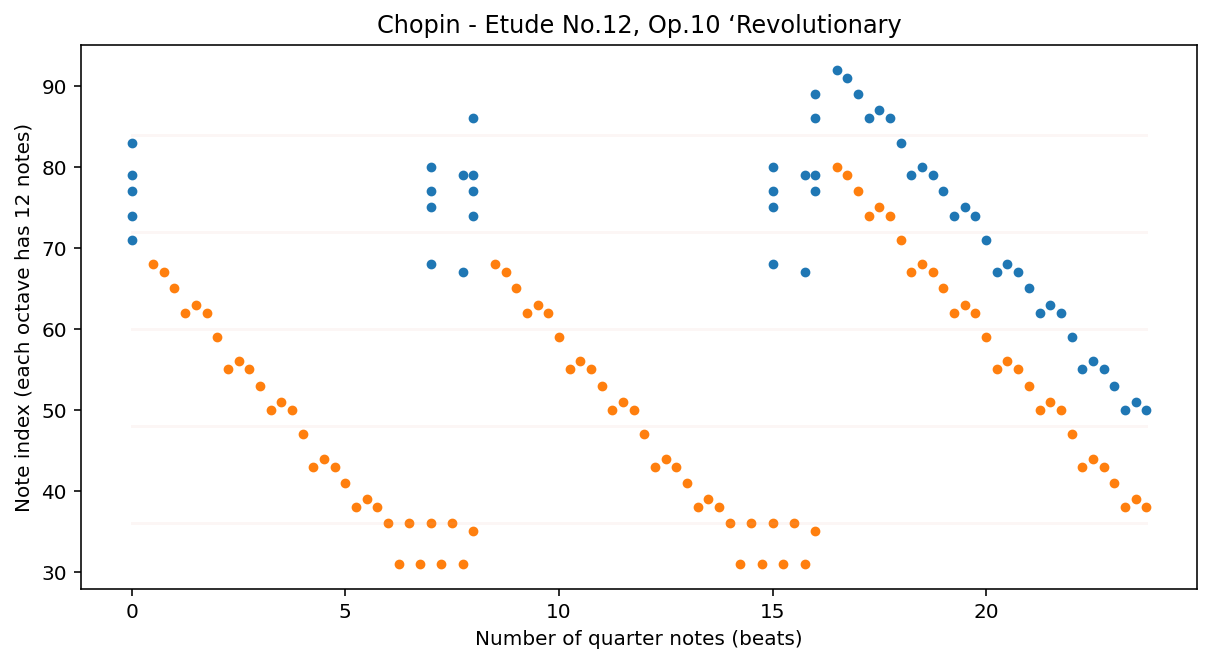

In [ ]:
def extract_notes(midi_part):
    
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midis):
    fig = plt.figure(figsize=(10, 5), facecolor='white')
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for midi in midis:
        top = midi.parts[0].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, s=15)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='#e8a7a6', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Chopin - Etude No.12, Op.10 ‘Revolutionary')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(ex_midis)

### 프로젝트

In [ ]:
# 데이터 불러오기 (중복 및 이상 데이터는 사전에 제거)
PLJ_DIR = '/content/drive/MyDrive/Colab Notebooks/project/project4/'
midi_files = glob.glob(PLJ_DIR +"midi_files/*.mid")

In [ ]:
def prep_notes(files):
    """ midi 파일을 전처리하는 함수입니다 """
    notes = []

    for file in files:

        midi = converter.parse(file)

        notes_to_parse = None

        # midi파일 음악을 단면화
        try:
            temp = instrument.partitionByInstrument(midi)
            notes_to_parse = temp.parts[0]. recurse()
        except:
            notes_to_parse = midi.flat.notes

        # 음악을 한번에 연주되는 음정 혹은 화음 단위로 쪼개기
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                
    return notes

In [ ]:
midi_notes = prep_notes(midi_files)

In [23]:
def prep_sequences(notes, length=10):
    """ notes를 sequence화 하는 함수입니다 """

    # 음정의 종류
    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(pitchnames)

    # 정수화를 위한 dictionary
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    # input 및 ouput의 sequences 
    network_input = []
    network_output = []

    for i in range(0, len(notes) - length, 1):
        sequence_in = notes[i:i + length]
        sequence_out = notes[i + length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # LSTM에 들어가기 좋은 형태로 reshape
    network_input = numpy.reshape(network_input, (n_patterns, length, 1))

    # input 정규화
    network_input = network_input / float(n_vocab)

    # output 원 핫 인코딩
    network_output = np_utils.to_categorical(network_output)

    return n_vocab, pitchnames, note_to_int, network_input, network_output

In [24]:
n_vocab, pitchnames, note_to_int, network_input, network_output = prep_sequences(midi_notes)

In [25]:
train_input, test_input, train_output, test_output = train_test_split(network_input, network_output, test_size=0.2, random_state=42)
print(f'train data: {len(train_output)}개, test data: {len(test_output)}개')

train data: 52356개, test data: 13089개


In [26]:
def create_model(network_input, n_vocab):
    """ 모델의 구조를 만드는 함수입니다 """

    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model

In [27]:
model = create_model(network_input, n_vocab)

In [36]:
def train(model, network_input, network_output):
    """ 학습을 진행하는 함수 """

    filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=10, batch_size=128, validation_data=(test_input, test_output), callbacks=callbacks_list)

In [37]:
train(model, train_input, train_output)

Epoch 1/10
410/410 [==============================] - 590s 1s/step - loss: 4.9451 - val_loss: 5.4730
Epoch 2/10
410/410 [==============================] - 553s 1s/step - loss: 4.8698 - val_loss: 7.6478
Epoch 3/10
410/410 [==============================] - 554s 1s/step - loss: 4.8401 - val_loss: 4.9993
Epoch 4/10
410/410 [==============================] - 551s 1s/step - loss: 4.8169 - val_loss: 4.7896
Epoch 5/10
410/410 [==============================] - 549s 1s/step - loss: 4.8000 - val_loss: 5.3858
Epoch 6/10
410/410 [==============================] - 551s 1s/step - loss: 4.7800 - val_loss: 4.7653
Epoch 7/10
410/410 [==============================] - 549s 1s/step - loss: 4.7620 - val_loss: 4.8592
Epoch 8/10
410/410 [==============================] - 551s 1s/step - loss: 4.7421 - val_loss: 5.4844
Epoch 9/10
410/410 [==============================] - 551s 1s/step - loss: 4.7219 - val_loss: 4.8720
Epoch 10/10
410/410 [==============================] - 549s 1s/step - loss: 4.7162 - val_lo

In [38]:
model.evaluate(test_input, test_output)

410/410 [==============================] - 53s 128ms/step - loss: 4.7416


4.741635322570801

In [39]:
# 런타임이 종료될 때를 대비하여 학습한 모델 피클화

pick_insert = open(PLJ_DIR+'model10.pkl','wb')
pickle.dump(model, pick_insert)
pick_insert.close()

INFO:tensorflow:Assets written to: ram://6b17f40b-74da-46cf-8c30-ada241e1937d/assets


INFO:tensorflow:Assets written to: ram://6b17f40b-74da-46cf-8c30-ada241e1937d/assets


In [40]:
# 피클화한 모델을 불러오기

pick_read = open(PLJ_DIR+'model10.pkl','rb')
model = pickle.load(pick_read)
pick_read.close()

### 새로운 음악 생성하기

In [41]:
new_midi_files = glob.glob(PLJ_DIR +"conan_main.mid")
new_notes = prep_notes(new_midi_files)

In [42]:
def pre_new_sequences(notes, note_to_int, n_vocab, length=10):
    """ 새로운 음악을 만들 notes를 sequence화 하는 함수입니다 """

    # 첫 부분 잘라오기
    new_sequences = new_notes[:length]
    network_input = [note_to_int[char] for char in new_sequences]

    # 정규화
    normalized_input = numpy.reshape(network_input, (1, length, 1))
    normalized_input = normalized_input / float(n_vocab)

    return network_input, normalized_input

In [79]:
network_input, normalized_input = pre_new_sequences(new_notes, note_to_int, n_vocab, length=10)

In [80]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ 새로운 sequence로 음악 이어 만들기 """

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input
    prediction_output = []

    for note_index in range(20):
        print(pattern)
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [81]:
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)

[0, 34, 0, 215, 181, 306, 270, 34, 0, 399]
[34, 0, 215, 181, 306, 270, 34, 0, 399, 34]
[0, 215, 181, 306, 270, 34, 0, 399, 34, 147]
[215, 181, 306, 270, 34, 0, 399, 34, 147, 34]
[181, 306, 270, 34, 0, 399, 34, 147, 34, 34]
[306, 270, 34, 0, 399, 34, 147, 34, 34, 306]
[270, 34, 0, 399, 34, 147, 34, 34, 306, 147]
[34, 0, 399, 34, 147, 34, 34, 306, 147, 147]
[0, 399, 34, 147, 34, 34, 306, 147, 147, 34]
[399, 34, 147, 34, 34, 306, 147, 147, 34, 34]
[34, 147, 34, 34, 306, 147, 147, 34, 34, 306]
[147, 34, 34, 306, 147, 147, 34, 34, 306, 147]
[34, 34, 306, 147, 147, 34, 34, 306, 147, 147]
[34, 306, 147, 147, 34, 34, 306, 147, 147, 147]
[306, 147, 147, 34, 34, 306, 147, 147, 147, 34]
[147, 147, 34, 34, 306, 147, 147, 147, 34, 95]
[147, 34, 34, 306, 147, 147, 147, 34, 95, 147]
[34, 34, 306, 147, 147, 147, 34, 95, 147, 147]
[34, 306, 147, 147, 147, 34, 95, 147, 147, 147]
[306, 147, 147, 147, 34, 95, 147, 147, 147, 147]


In [82]:
def create_midi(prediction_output):
    """ 예측한 notes를 midi 파일로 변환하는 함수입니다. """

    offset = 0
    output_notes = []

    # 모델의 결과를 음정 혹은 화음으로 변환
    for pattern in prediction_output:
        # 화음인 경우
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # 하나의 음인 경우
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='/content/drive/MyDrive/Colab Notebooks/project/project4/output10.mid')

In [83]:
create_midi(prediction_output)